In [26]:
!pwd

/users/juanjose/git/telemanom/telemanom


In [2]:
import multiprocessing as mp
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.callbacks import History, EarlyStopping, Callback
import tensorflow as tf
print(tf.version.VERSION)

2.6.2


In [3]:
test_list = [
	{'Course': "C++", 'Author': "Jerry"},
	{'Course': "Python", 'Author': "Mark"},
	{'Course': "Java", 'Author': "Paul"}]

res = list(filter(lambda test_list: test_list['Author'] == 'Jerry', test_list))
print(res[0]['Author'])



Jerry


In [4]:
class Parallel_Params:
    def __init__(self, config, i, chan_id, rid):
        self.config = config
        self.i = i
        self.chan_id = chan_id
        self.id =rid

In [5]:
l = []
for i in range(3):
    l.append(Parallel_Params("c", 1,i,2))

In [6]:
for i in iter(l):
    print(i)

In [9]:
os.chdir('telemanom')
os.getcwd()

'/users/juanjose/git/telemanom/telemanom'

In [10]:
from channel import Channel
from helpers import Config

In [11]:
cfg = Config("config.yaml")

In [12]:
ch = Channel(cfg, 'A-2')

In [13]:
ch.load_data()

[Errno 2] No such file or directory: 'data/train/A-2.npy'
Source data not found, may need to add data to repo: <link>


TypeError: object of type 'NoneType' has no len()

In [14]:
trn = np.load("../data/train/A-2.npy")

In [15]:
data = []
for i in range(len(trn) - cfg.l_s - cfg.n_predictions):
    data.append(trn[i:i + cfg.l_s + cfg.n_predictions])
data = np.array(data)

assert len(data.shape) == 3
np.random.shuffle(data)
X_train = data[:, :-cfg.n_predictions, :]
y_train = data[:, -cfg.n_predictions:, 0]  # telemetry value is at position 0

In [16]:
X_train.shape

(2388, 250, 25)

In [17]:
df[0].plot()

NameError: name 'df' is not defined

In [33]:
from keras.layers.recurrent import LSTM
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, Flatten, RepeatVector
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
from keras.models import Sequential

In [27]:
model = Sequential()

model.add(LSTM(
    cfg.layers[0],
    input_shape=(None, trn.shape[1]),
    return_sequences=True))
model.add(Dropout(cfg.dropout))

model.add(LSTM(
    cfg.layers[1],
    return_sequences=False))
model.add(Dropout(cfg.dropout))

model.add(Dense(
    cfg.n_predictions))
model.add(Activation('linear'))

In [52]:
cfg.n_predictions

10

In [54]:
for i in range(len(model.layers)):
    print(model.layers[i].name)
    print(model.layers[i].input_shape)
    print(model.layers[i].output_shape)

conv2d_4
(None, None, 250, 25)
(None, None, 248, 64)
dropout_8
(None, None, 248, 64)
(None, None, 248, 64)
dense_9
(None, None, 248, 64)
(None, None, 248, 25)
flatten_2
(None, None, 248, 25)
(None, None)


In [65]:
model = Sequential()
model.add(Conv1D(filters=64,
                 kernel_size=10,
                 activation='relu',
                 input_shape=(None, 25)))
model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu'))
model.add(Dropout(cfg.dropout))
model.add(Dense(
    25))
model.add(LSTM(
    cfg.layers[1],
    return_sequences=False))
model.add(Dropout(cfg.dropout))

model.add(Dense(
    cfg.n_predictions))
model.add(Activation('linear'))
model.add(Dense(
    cfg.n_predictions))
model.add(Activation('linear'))

In [23]:
cbs = [History(), EarlyStopping(monitor='val_loss',
                                patience=cfg.patience,
                                min_delta=cfg.min_delta,
                                verbose=0)]

In [66]:
model.compile(loss=cfg.loss_metric,
                   optimizer=cfg.optimizer)

hist4 = model.fit(X_train,
               y_train,
               batch_size=cfg.lstm_batch_size,
               epochs=cfg.epochs,
               validation_split=cfg.validation_split,
               callbacks=cbs,
               verbose=True)

Epoch 1/35
30/30 [==============================] - 11s 272ms/step - loss: 0.2443 - val_loss: 0.1288
Epoch 2/35
30/30 [==============================] - 8s 261ms/step - loss: 0.1012 - val_loss: 0.0501
Epoch 3/35
30/30 [==============================] - 8s 260ms/step - loss: 0.0553 - val_loss: 0.0386
Epoch 4/35
30/30 [==============================] - 8s 263ms/step - loss: 0.0464 - val_loss: 0.0338
Epoch 5/35
30/30 [==============================] - 8s 262ms/step - loss: 0.0404 - val_loss: 0.0317
Epoch 6/35
30/30 [==============================] - 8s 260ms/step - loss: 0.0389 - val_loss: 0.0307
Epoch 7/35
30/30 [==============================] - 8s 262ms/step - loss: 0.0381 - val_loss: 0.0311
Epoch 8/35
30/30 [==============================] - 8s 262ms/step - loss: 0.0361 - val_loss: 0.0292
Epoch 9/35
30/30 [==============================] - 8s 264ms/step - loss: 0.0345 - val_loss: 0.0292
Epoch 10/35
30/30 [==============================] - 8s 261ms/step - loss: 0.0336 - val_loss: 0.030

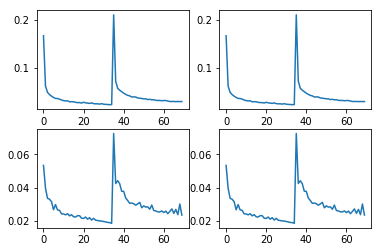

In [45]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(2,2)
ax[0, 0].plot(hist.history['loss'])
ax[0, 1].plot(hist2.history['loss'])
ax[1, 0].plot(hist.history['val_loss'])
ax[1, 1].plot(hist2.history['val_loss'])

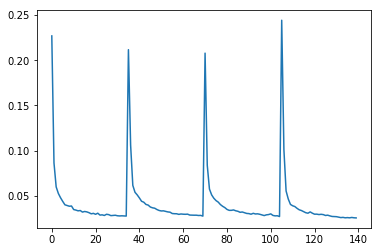

In [67]:
plt.plot(hist4.history['loss'])

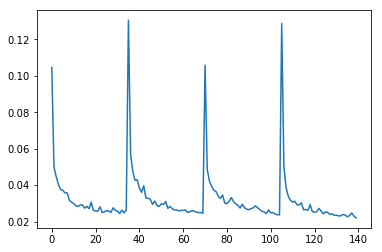

In [68]:
plt.plot(hist4.history['val_loss'])